In [5]:
import json, sys, matplotlib, plotly, glob, pytz, sys, os, time
import numpy as np; import seaborn as sns; import pandas as pd
from datetime import datetime, date, timezone, timedelta
import urllib.request

#Graphing with Plotly: 
import plotly.graph_objects as go

#Matplotlib: 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Make it look pretty on retina displays:
%config InlineBackend.figure_format = 'retina'

# Plotting @realDonaldTrump tweets

First, download all of Trump's tweets from TheTrumpArchive.com
https://drive.google.com/file/d/1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6/view?usp=sharing

We'll save the file as "trump_tweets.csv" for future use

In [6]:
# Read in the local file and check it out:
tweets = pd.read_csv('trump_tweets.csv')
print("Read in {} tweets".format(len(tweets)))
tweets.head(2)

Read in 56571 tweets


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f


This next part cleans the data and normalizes it to Eastern Time

In [7]:
# Cast booleans
tweets.isRetweet = tweets.isRetweet.apply(lambda b: b == 't')
tweets.isFlagged = tweets.isFlagged.apply(lambda b: b == 't')
tweets.isDeleted = tweets.isDeleted.apply(lambda b: b == 't')

# Cast Timestamp
tweets.date = tweets.date.apply(pd.Timestamp)

# Localize Dates
ET = pytz.timezone('US/Eastern')
tweets['eastern_time'] = tweets.date.apply(lambda d: ET.localize(d))

# Use the localized dates 
tweets['tz_adjusted_date'] = tweets.apply(lambda row: (row.date + row.eastern_time.utcoffset()), axis=1)
tweets['hour']    = tweets.tz_adjusted_date.apply(lambda d: d.hour)
tweets['day']    = tweets.tz_adjusted_date.apply(lambda d: d.date())
tweets['month']  = tweets.tz_adjusted_date.apply(lambda d: date(d.year, d.month, 15))
tweets['year']   = tweets.day.apply(lambda d: d.year)

#This one is the trickiest, we only care about the time of day, so we'll make a fake date of 2000-01-01: 
tweets['normed_to_2000'] = tweets.tz_adjusted_date.apply(lambda d: datetime(2000,1,1,d.hour, d.minute,d.second))

#How's it look?
tweets.head(2)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,eastern_time,tz_adjusted_date,hour,day,month,year,normed_to_2000
0,98454970654916608,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,2011-08-02 18:07:48,False,2011-08-02 18:07:48-04:00,2011-08-02 14:07:48,14,2011-08-02,2011-08-15,2011,2000-01-01 14:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,False,2020-03-03 01:34:50-05:00,2020-03-02 20:34:50,20,2020-03-02,2020-03-15,2020,2000-01-01 20:34:50


In [20]:
tweets.groupby('day').aggregate({'id':'count','isRetweet':sum,
'isDeleted':sum,'isFlagged':sum}).sort_values(by='isFlagged',ascending=False)

,id,isRetweet,isDeleted,isFlagged
day,,,,
2020-12-06,62,39,1,20
2020-11-21,38,9,3,15
2020-12-02,23,6,0,14
2020-11-27,32,16,0,13
2020-11-25,49,31,1,12
...,...,...,...,...
2014-07-25,7,0,0,0
2014-07-26,4,0,0,0
2014-07-28,15,0,0,0


In [9]:
# We're most interested in working with data from 2015 to 2020, so let's make a new dataframe we can play with: 
_slice = pd.DataFrame( tweets[tweets.day > date(2015,1,1)] )

First question, how many tweets posted each year? 

In [31]:
print("Tweets Per Year: ")
_slice.groupby('year').aggregate({'id':'count'}).transpose()

Tweets Per Year: 


year,2015,2016,2017,2018,2019,2020,2021
id,7511,4223,2602,3572,7835,12220,151


To Visualize:

38,114 tweets in total


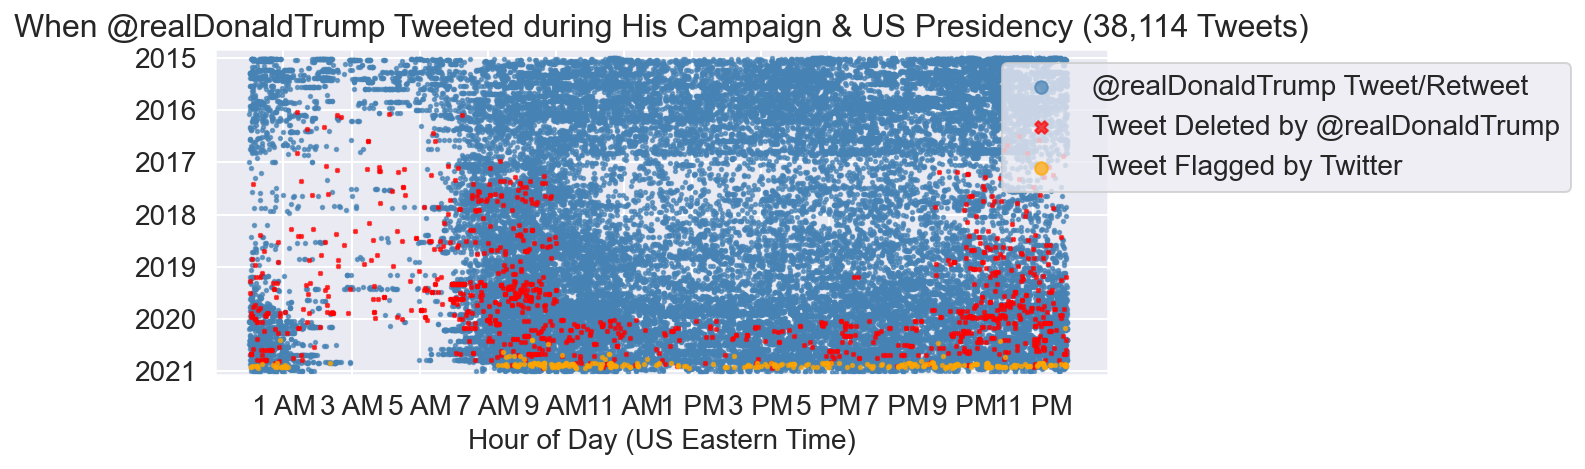

In [47]:
def make_scatter_plot(figsize=(12,18)):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1,1, figsize=figsize)

    # Not deleted, not flagged
    _slice[ ~_slice.isDeleted & ~_slice.isFlagged ].plot.scatter(
        x='normed_to_2000',y='day', color='steelblue', s=3, alpha=0.7, marker='o', ax=ax, label="@realDonaldTrump Tweet/Retweet")

    # Deleted tweets
    _slice[ _slice.isDeleted ].plot.scatter(
        x='normed_to_2000',y='day', color='red', s=3, alpha=0.7, marker='X', ax=ax, label="Tweet Deleted by @realDonaldTrump")

    # Flagged tweets
    _slice[ _slice.isFlagged ].plot.scatter(
        x='normed_to_2000',y='day', color='orange', s=3, alpha=0.7, marker='o', ax=ax, label="Tweet Flagged by Twitter")

    # Display tweets in ascending order down the page
    ax.invert_yaxis(); ax.set_ylim(date(2021,2,1), date(2014,11,1))

    # Set the axis labels
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y", tz=None));

    ax.set_xticks(np.arange(datetime(2000,1,1,1,0,0), datetime(2000,1,1,23,55,59), timedelta(hours=2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%-I %p", tz=None));
    ax.set_xlim(datetime(1999,12,31, 23, 0, 0))
    ax.tick_params(labelsize=14)

    lgnd = ax.legend(ncol=1, fontsize=14, loc='upper center', bbox_to_anchor=(1.2,1))
    for handle in lgnd.legendHandles:
        handle._sizes = [40]

    ax.set_title("When @realDonaldTrump Tweeted during His Campaign & US Presidency ({:,} Tweets)".format(len(_slice)),
                 fontsize=16)
    ax.set_ylabel(None); ax.set_xlabel("Hour of Day (US Eastern Time)", fontsize=14);
    print("{:,} tweets in total".format(len(_slice)))

make_scatter_plot(figsize=(8,3))

And that's the same plot from [this post](https://post-mortem-realdonaldtrump.medium.com/post-mortem-of-realdonaldtrump-an-introduction-b98a5764437d)

But can we do some more?

_To check what words might be best to search for, use the search function on [TheTrumpArchive.com](https://www.thetrumparchive.com/)_

In [48]:
# Tweets in all capitals?
_slice['isCapital'] = _slice.text.str.isupper()

In [49]:
perfect_words    = set(['perfect','incredible','amazing', 'magnificent'])
phony_words      = set(['fake','phony','hoax'])

_slice['hasPhony']       = _slice.text.apply(lambda text: len(set(text.lower().split()) & phony_words)>0)
_slice['hasPerfect']     = _slice.text.apply(lambda text: len(set(text.lower().split()) & perfect_words)>0)
_slice['hasExclamation'] = _slice.text.apply(lambda text: '!' in text)

In [50]:
# What do our tweets look like now?
_slice.head(3)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,eastern_time,...,hour,day,month,year,normed_to_2000,isCapital,hasPhony,hasPerfect,hasExclamation,wrap_text
1,1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,False,2020-03-03 01:34:50-05:00,...,20,2020-03-02,2020-03-15,2020,2000-01-01 20:34:50,False,False,False,True,I was thrilled to be back in the Great city of...
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17 03:22:47,False,2020-01-17 03:22:47-05:00,...,22,2020-01-16,2020-01-15,2020,2000-01-01 22:22:47,False,False,False,False,RT @CBS_Herridge: READ: Letter to surveillance...
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,False,2020-09-12 20:10:58-04:00,...,16,2020-09-12,2020-09-15,2020,2000-01-01 16:10:58,False,False,False,True,The Unsolicited Mail In Ballot Scam is a major...


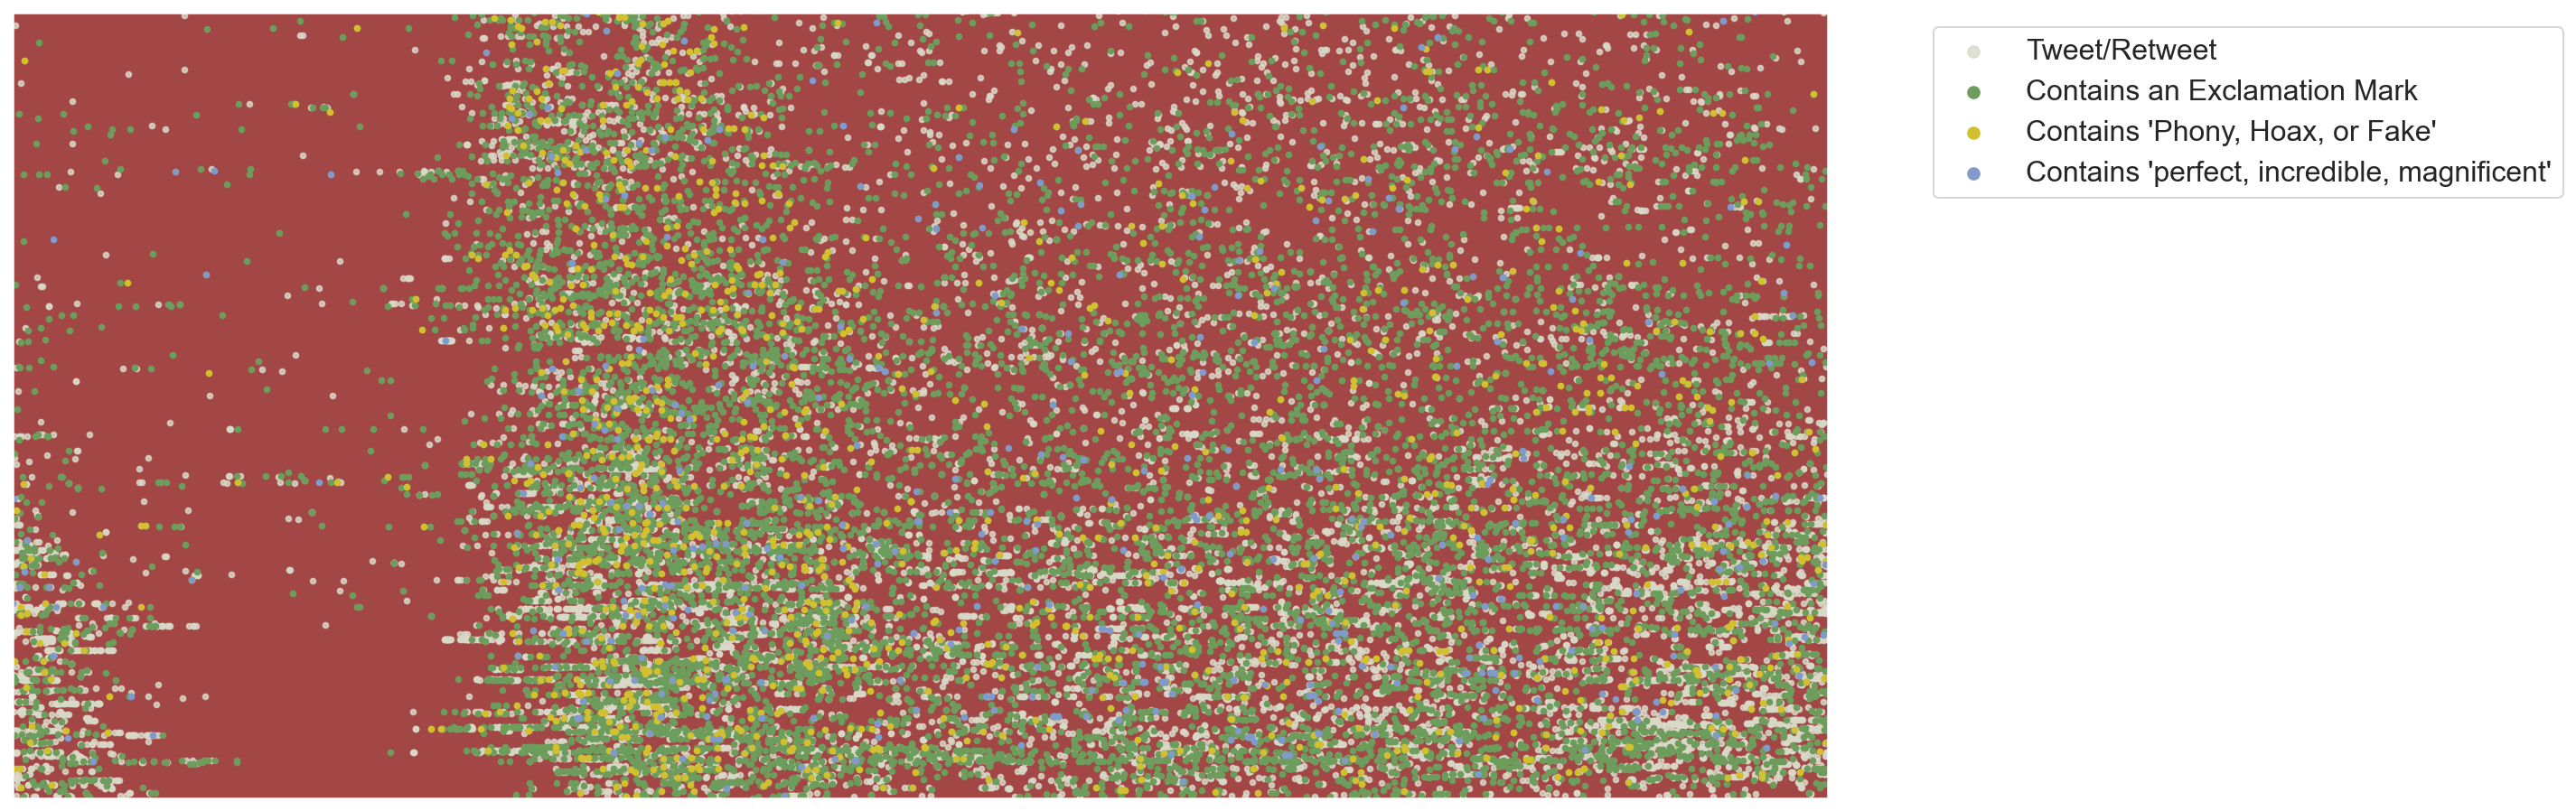

In [52]:
def make_stylized_plot(figsize=(18,8)):
    # Now let's make our first stylized plot:
    figsize=(18,8)
    sns.set_style('white')
    sns.set(rc={'axes.facecolor':'#a24646'})

    # "boring" tweets first as a base: 
    ax = _slice[
            ~ _slice.isCapital & ~_slice.hasPhony & ~_slice.hasPerfect & ~_slice.hasExclamation
        ].plot.scatter(
        x='normed_to_2000',y='day', color='#d9d9c8', s=8, alpha=0.8, marker='o', figsize=figsize, 
        label="Tweet/Retweet")

    #Now the more interesting tweets; color palette from: 
    #https://www.color-hex.com/color-palette/104603
    _slice[ _slice.hasExclamation & ~_slice.isRetweet].plot.scatter(
        x='normed_to_2000',y='day', color='#6d9d5c', s=8, alpha=1, marker='o', ax=ax,
        label="Contains an Exclamation Mark")

    _slice[ _slice.hasPhony].plot.scatter(
        x='normed_to_2000',y='day', color='#d3c02f', s=8, alpha=1, marker='o', ax=ax,
        label="Contains 'Phony, Hoax, or Fake'")

    _slice[ _slice.hasPerfect].plot.scatter(
        x='normed_to_2000',y='day', color='#809acc', s=8, alpha=1, marker='o', ax=ax,
        label="Contains 'perfect, incredible, magnificent'")

    lgnd = ax.legend(bbox_to_anchor =(1.05,1), facecolor='white', fontsize=16)
    for handle in lgnd.legendHandles:
        handle._sizes = [40]
    ax.invert_yaxis(); ax.set_xticks([]); ax.set_yticks([])
    ax.grid(False); ax.set_ylabel(None); ax.set_xlabel(None)
    ax.set_ylim(date(2021,1,8), date(2017,1,20))
    ax.set_xlim(datetime(2000,1,1,0, 0, 0),datetime(2000,1,1,23,59,59));
make_stylized_plot(figsize=(4,3))

It's a different color palette, highlighting specific tweets of interest and removing the axis; some type of abstract art?

### A closer look at time of day?

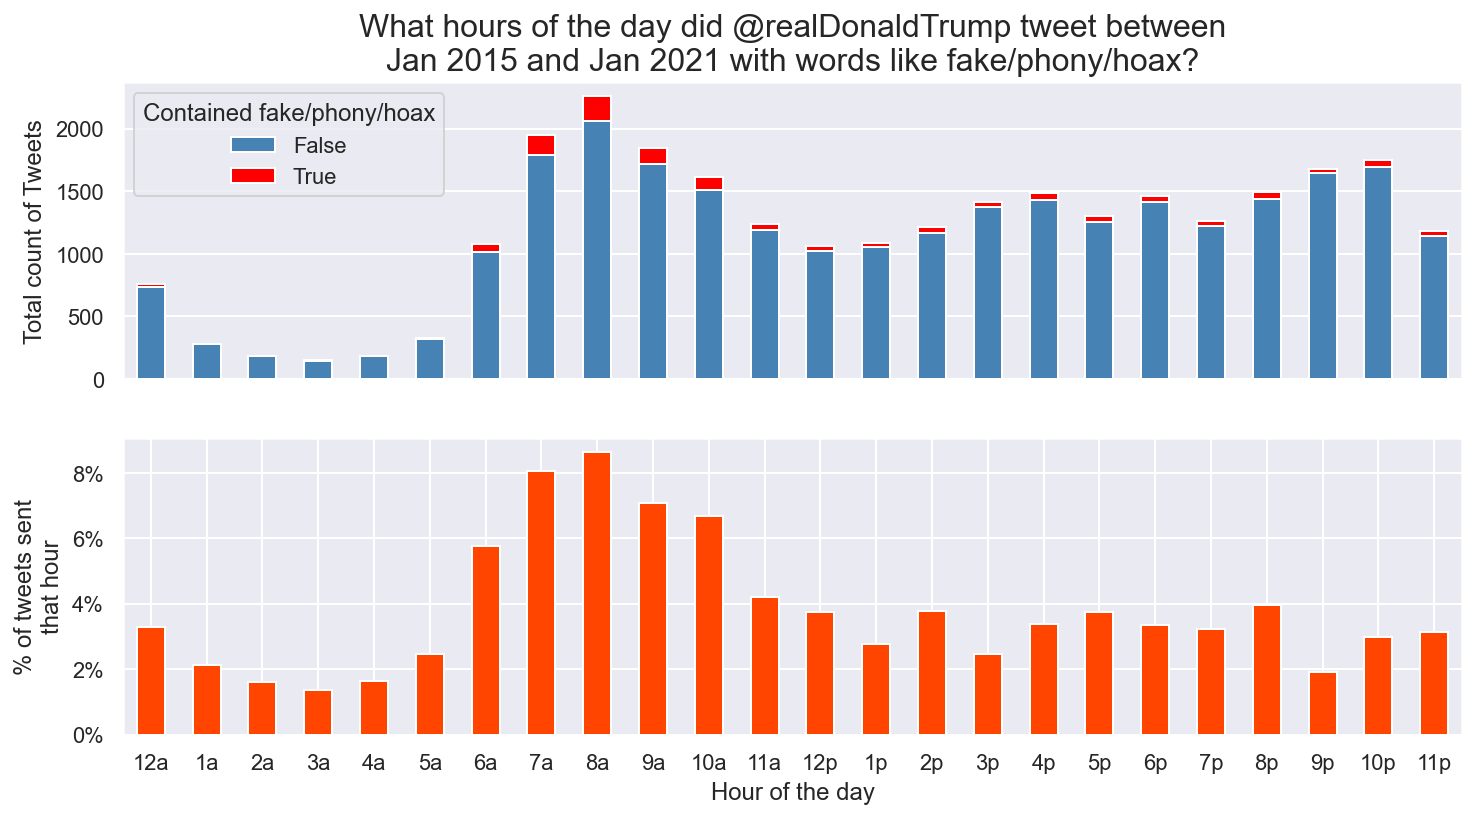

In [53]:
@ticker.FuncFormatter
def pretty_xaxis_hours(x,pos):
    if x==0:
        return "12a"
    if x==12:
        return "12p"
    elif x<12:
        return "{}a".format(x) 
    else:
        return "{}p".format(x-12)


def plot_type_of_tweet(column='hasPhony', words=phony_words):
    
    sns.set_style('darkgrid')

    fig, axes = plt.subplots(2,1, figsize=(12,6))
    ax1 = axes[0]; ax2 = axes[1]

    gb_hour = _slice[~_slice.isRetweet].groupby(['hour',column]).aggregate({'id':'count'}).unstack()
    gb_hour.columns = gb_hour.columns.get_level_values(1)
    gb_hour.plot.bar(stacked=True, ax=ax1, color=['steelblue','red'])

    ax1.set_title("What hours of the day did @realDonaldTrump tweet between\nJan 2015 and Jan 2021 with words like {}?".format(
        "/".join(words)), fontsize=16)
    ax1.set_ylabel("Total count of Tweets");
    ax1.set_xticks([]); ax1.set_xlabel(None);

    ax2 = (gb_hour[True] / (gb_hour[False] + gb_hour[True])*100).plot.bar(ax=ax2, color='orangered')
    # ax2.set_title("What % of @realDonaldTrump tweets contained the words: phony, hoax, or fake \ndepending on the time of day he tweeted?")
    ax2.set_ylabel("% of tweets sent\nthat hour");
    ax2.set_xlabel("Hour of the day");
    plt.xticks(rotation=0);

    ax1.legend(title="Contained {}".format("/".join(words)))

    ax2.xaxis.set_major_formatter(pretty_xaxis_hours);
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{}%".format(int(x))));
plot_type_of_tweet()

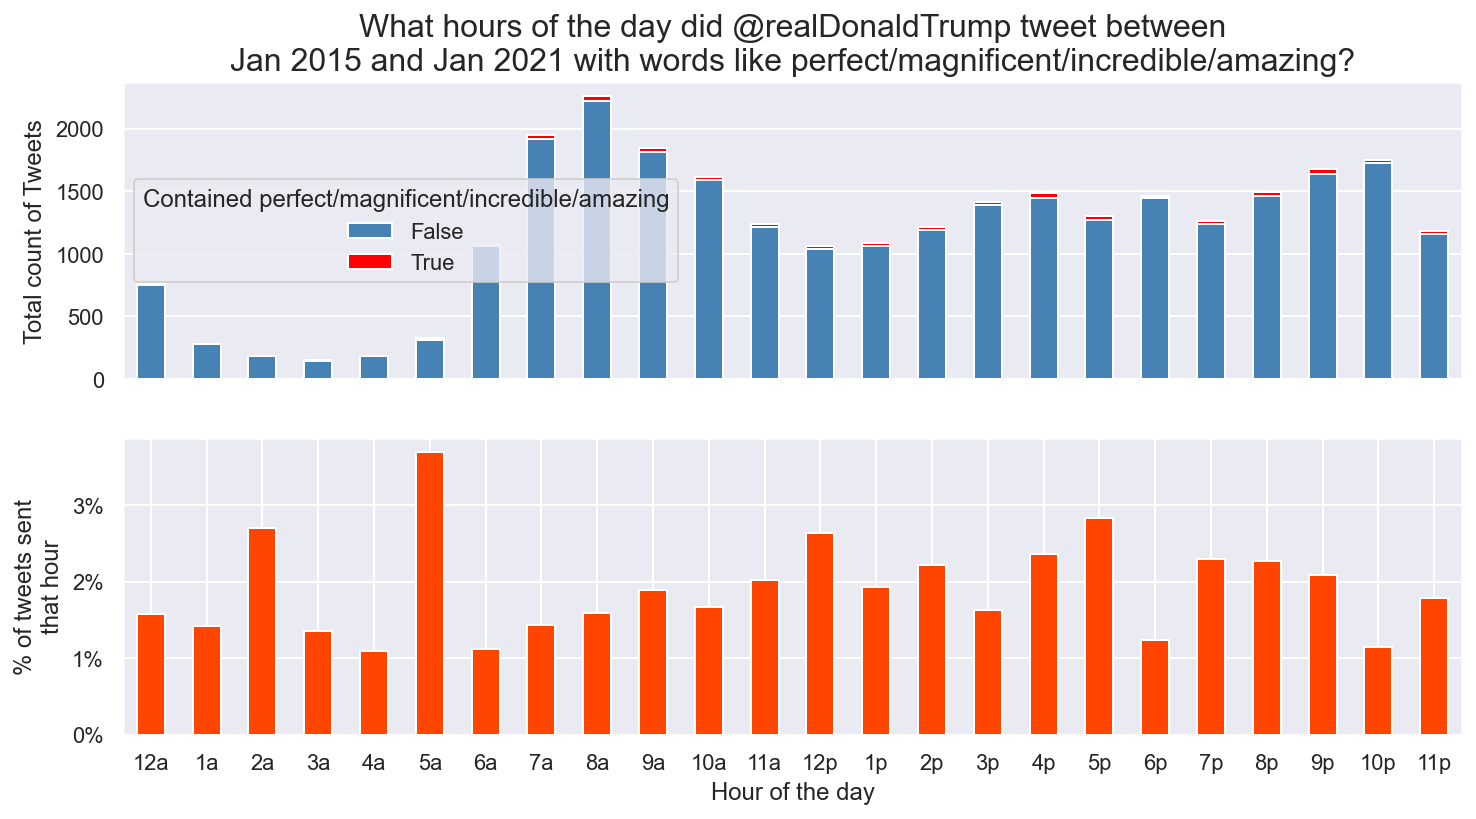

In [54]:
plot_type_of_tweet(column='hasPerfect', words=perfect_words)

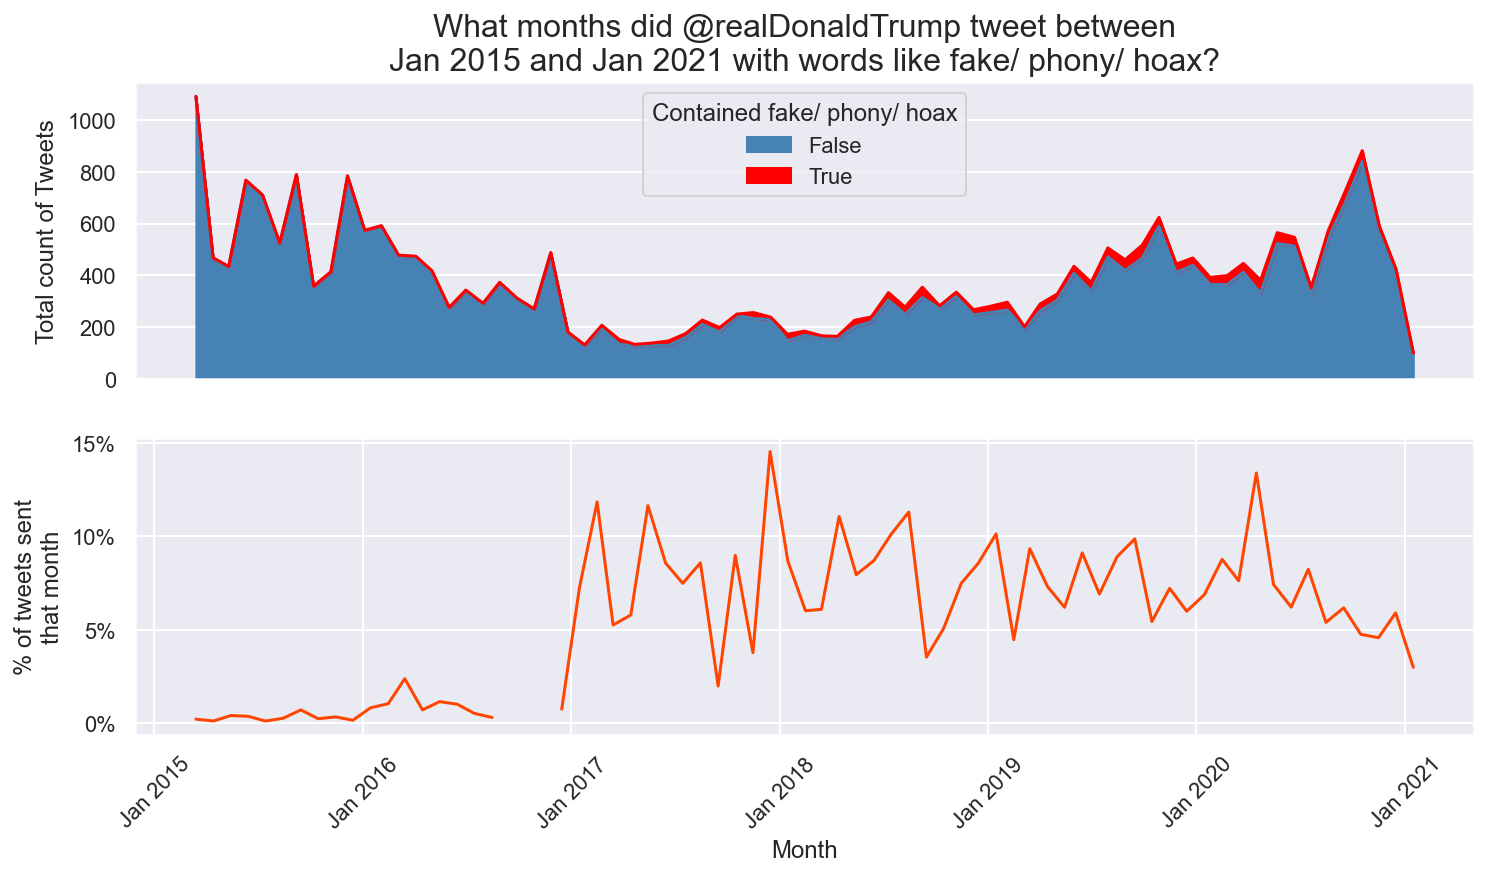

In [55]:
def plot_type_of_tweet_by_month(column='hasPhony', words=phony_words):
    
    sns.set_style('darkgrid')

    fig, axes = plt.subplots(2,1, figsize=(12,6))
    ax1 = axes[0]; ax2 = axes[1]

    gb_hour = _slice[~_slice.isRetweet].groupby(['month',column]).aggregate({'id':'count'}).unstack()
    gb_hour.columns = gb_hour.columns.get_level_values(1)
    gb_hour.plot.area(stacked=True, ax=ax1, color=['steelblue','red'])

    ax1.set_title("What months did @realDonaldTrump tweet between\nJan 2015 and Jan 2021 with words like {}?".format(
        "/ ".join(words)), fontsize=16)
    ax1.set_ylabel("Total count of Tweets");
    ax1.set_xticks([]); ax1.set_xlabel(None);

    ax2 = (gb_hour[True] / (gb_hour[False] + gb_hour[True])*100).plot(ax=ax2, color='orangered')
    # ax2.set_title("What % of @realDonaldTrump tweets contained the words: phony, hoax, or fake \ndepending on the time of day he tweeted?")
    ax2.set_ylabel("% of tweets sent\nthat month");
    ax2.set_xlabel("Month");
    plt.xticks(rotation=45);

    ax1.legend(title="Contained {}".format("/ ".join(words)))
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"));
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{}%".format(int(x))));
plot_type_of_tweet_by_month()

It was really once he took office when started using these terms

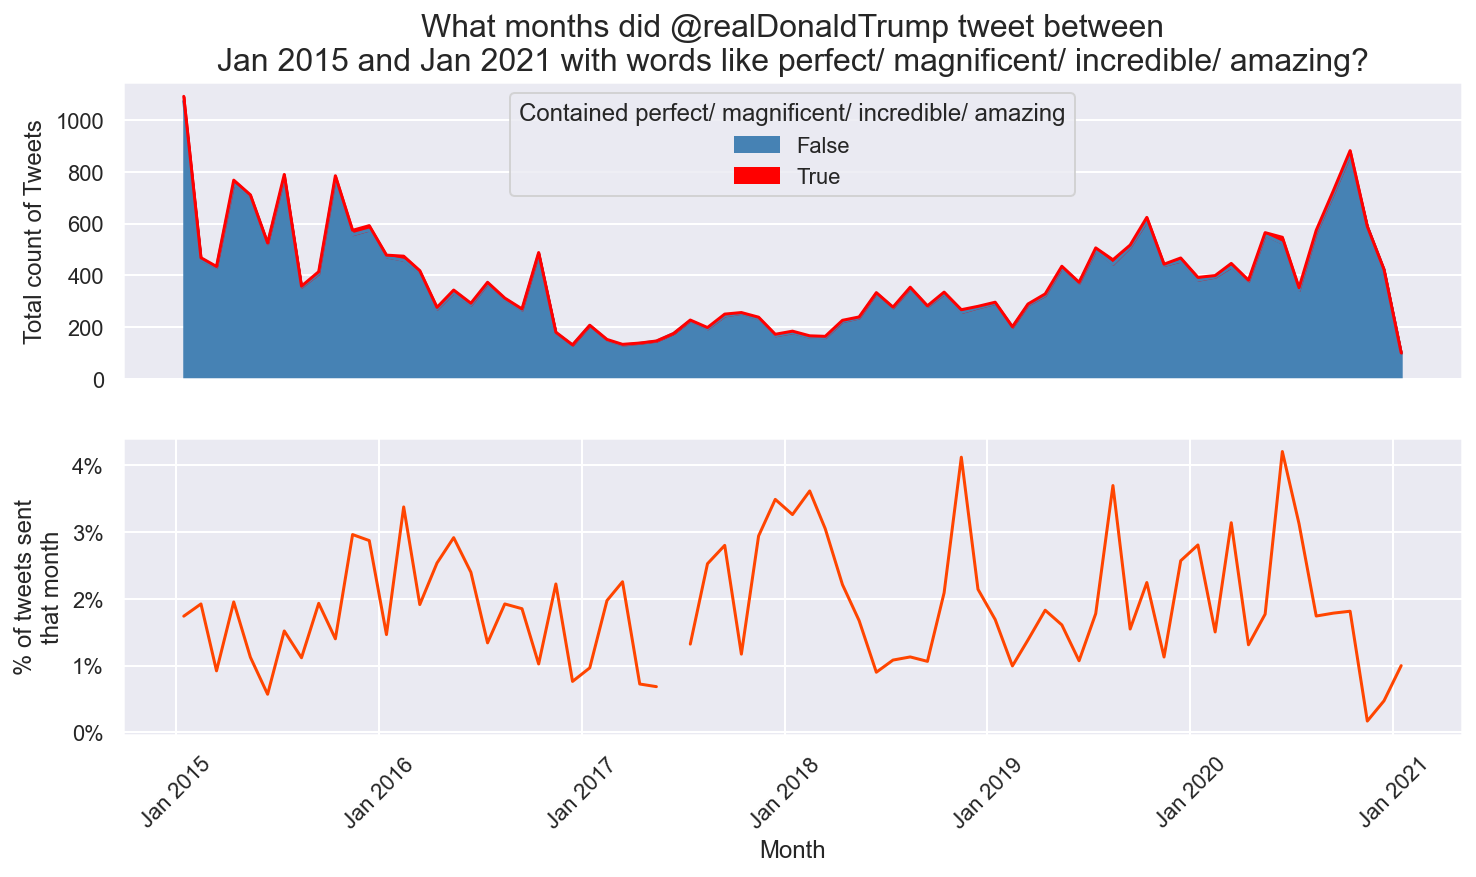

In [56]:
plot_type_of_tweet_by_month(column='hasPerfect', words=perfect_words)

## Now let's make it interactive with Plotly

In [57]:
# shorter text that wraps:
def make_html_wrap_text(s):
    string = ""
    words = s.split(" ")
    column_count = 0;
    for word in words: 
        column_count+=len(word)
        if column_count > 60:
            string += "<br>"
            column_count = 0
        string += word + " "
    return string
_slice['wrap_text'] = _slice.text.apply(make_html_wrap_text)

In [58]:
def build_plot(df, height=1000, title="@realDonaldTrump Interactive Tweet Explorer (beta)"):
    fig = go.Figure()
    
    df = pd.DataFrame(df); df['wrap_text'] = df.text.apply(make_html_wrap_text)
    
    all_tweets   = df[~df.isRetweet& ~df.isDeleted & ~df.isFlagged]
    all_retweets = df[df.isRetweet & ~df.isDeleted & ~df.isFlagged]
    phony        = df[~df.isRetweet & df.hasPhony]
    perfect      = df[~df.isRetweet & df.hasPerfect]
    deleted      = df[df.isDeleted]
    flagged      = df[df.isFlagged]
    
    hover_template ='%{y} | %{text}'
    
    fig.add_trace(go.Scattergl(
            name = "All Tweets by @realDonaldTrump<br>({:,} tweets)".format(len(all_tweets)),
            x    = all_tweets.normed_to_2000, 
            y    = all_tweets.tz_adjusted_date, mode = 'markers',
            marker = dict(
                size  = 7,
                color = 'steelblue',
                opacity = 0.5),
            hovertemplate = hover_template,
            text = list(all_tweets.wrap_text),
            showlegend = True,
    ))
    
    fig.add_trace(go.Scattergl(
            name = "All Retweets by @realDonaldTrump<br>({:,} retweets)".format(len(all_retweets)),
            x    = all_retweets.normed_to_2000, 
            y    = all_retweets.tz_adjusted_date, mode = 'markers',
            marker = dict(
                size  = 7,
                color = 'steelblue',
                symbol= 'triangle-up',
                opacity = 0.5),
            hovertemplate = hover_template,
            text = list(all_retweets.wrap_text),
            showlegend = True,
    ))
    fig.add_trace(go.Scattergl(
            name = "Tweets deleted by @realDonaldTrump<br>({:,} tweets)".format(len(deleted)),
            x    = deleted.normed_to_2000, 
            y    = deleted.tz_adjusted_date, mode = 'markers',
            marker = dict(
                size  = 7,
                color = 'red',
                opacity = 0.8),
            hovertemplate = hover_template,
            text = list(deleted.wrap_text),
            showlegend = True,
    ))
    fig.add_trace(go.Scattergl(
            name = "Tweets flagged by Twitter<br>({:,} tweets)".format(len(flagged)),
            x    = flagged.normed_to_2000, 
            y    = flagged.tz_adjusted_date, mode = 'markers',
            marker = dict(
                size  = 7,
                color = 'orange',
                opacity = 0.9),
            hovertemplate = hover_template,
            text = list(flagged.wrap_text),
            showlegend = True,
    ))
    fig.add_trace(go.Scattergl(
            name = "Tweets with <br>'{}' <br>({:,} tweets)".format("/".join(phony_words), len(phony)),
            x    = phony.normed_to_2000, 
            y    = phony.tz_adjusted_date, mode = 'markers',
            marker = dict(
                size  = 7,
                color = 'purple',
                opacity = 0.9),
            hovertemplate = hover_template,
            text = list(phony.wrap_text),
            showlegend = True,
    ))
    fig.add_trace(go.Scattergl(
            name = "Tweets with <br>'{}' <br>({:,} tweets)".format("/".join(perfect_words), len(perfect)),
            x    = perfect.normed_to_2000, 
            y    = perfect.tz_adjusted_date, mode = 'markers',
            marker = dict(
                size  = 7,
                color = 'green',
                opacity = 0.9),
            hovertemplate = hover_template,
            text = list(perfect.wrap_text),
            showlegend = True,
    ))
    
    fig.update_layout(
        title = title,
        yaxis = dict(autorange="reversed"),
        width=1400,
        height=height,
        margin=dict(r=0, l=0, b=0, t=30),
        hoverlabel_align = 'left'
    )
    fig.update_xaxes(
        tickformat="%I:%M:%S %p"
    )

    return fig

x = build_plot(_slice[_slice.day >= date(2020,1,1)], title="@realDonaldTrump Interactive Tweet Explorer (beta) - 2020-2021")
with open('docs/interactive_2020.html','w') as outFile:
    plotly.io.write_html(x, outFile)
print("Wrote file 'docs/interactive_2020.html'")
# x.show()

Wrote file 'docs/interactive_2020.html'


In [59]:
x = build_plot(_slice[_slice.day >= date(2015,1,1)], title="@realDonaldTrump Interactive Tweet Explorer (beta) - 2015-2021")
with open('docs/interactive_2015-2021.html','w') as outFile:
    plotly.io.write_html(x, outFile)
print("Wrote file 'docs/interactive_2015-2021.html'")
# x.show()

Wrote file 'docs/interactive_2015-2021.html'
